In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [26]:
treated_data_rep = r'../0_Data/wrangled/' 
HKDaily_AGG = pd.read_pickle(treated_data_rep+"HKDaily_AGG.pkl")
HKDaily_AGG

,TX,RR,UM
Date,,,
1884-01-01,15.3,NaN,NaN
1884-01-02,17.1,NaN,NaN
1884-01-03,19.6,NaN,NaN
1884-01-04,23.2,NaN,NaN
1884-01-05,19.4,NaN,NaN
...,...,...,...
2025-02-24,18.825,0.0,70.909091
2025-02-25,19.069444,0.02381,74.136364
2025-02-26,20.491667,0.681818,82.363636


In [27]:
HKDaily_AGG_for_acf = HKDaily_AGG[['TX']]

# Decomposition of HK weather series

In this section, we will decompose the time series of Temperature, Humidity and Rainfall series of two cities in different components. As it is well known, any kind of time series can be decomposed into four terms:

- **Trend**: A trend is a long-term movement of the series. It is a smooth and steady movement of a time series in a particular direction (increasing or decreasing).  
- **Seasonal**: A seasonal term is the regular variation in relation to the seasonal period. 
- **Cyclical**: It is also a regular variation as the seasonal term, but its regularity is not totally explained by the season, and the period of regularity is not always fixed (Economic recession can come by 10 to 15 years, and its due can differ from time to time) Plus, in terms of its signification, it is more about economical cycles or other cyclical movement than the natural season.
- **Random value (error term)**: The remaining value after removing the trend, seasonal termm cyclical term is seen as a random value. We call it 'error term' or 'noise' too. It represents the inexplained part of our time series.

The final time series is a mixture of these four elements. It can be a combination by different ways, but most commonly observed and used is by sum (additive relation) or by multiplication (multiplicative relation). 

## (1) Autocorrelation plot

To analyze the different components of a time series, before putting it into a decomposition algorithme such as STL (LOESS), it is good to see how the autocorrelation and the partial autocorrelation of the original series look like. Some caracteristics in the autocorrelation and in the partial autocorrelation can reveal the trend and the seasonal/cyclical behaviour.

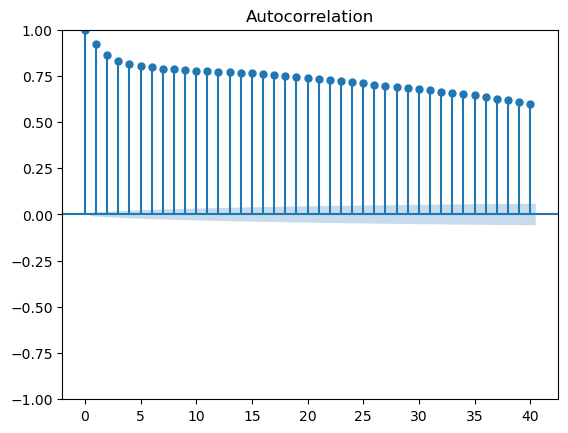

In [28]:
sm.graphics.tsa.plot_acf(HKDaily_AGG_for_acf.squeeze(), lags=40)
plt.show()

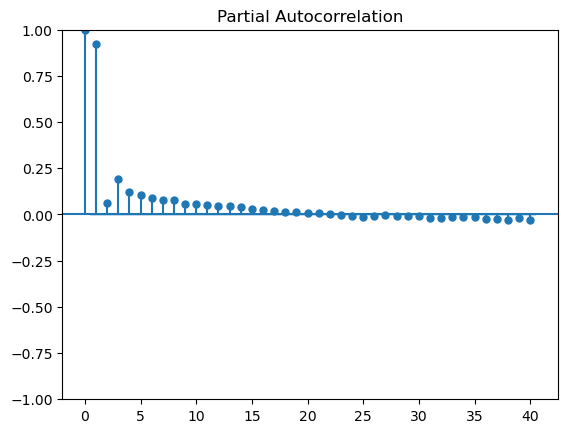

In [29]:
sm.graphics.tsa.plot_pacf(HKDaily_AGG_for_acf.squeeze(), lags=40, method="ywm")
plt.show()

While the autocorrelation plot makes us presume an existence of a trend term in the series, and the autocorrelation plot helps us to have an AR term of (p = t-1) in a classic time series models, these graphs show that the daily frenquency series is too frequent to show the year-round seasonal pattern that we have already noticed in the "0_Solely HK weather data preview" part. So here, it will be relevent to pass to the monthly level by averaging the series by month.

In [46]:
# Day of the year
HKDaily_AGG['day_of_year'] = HKDaily_AGG['Date'].dt.dayofyear

# Add mean values :
mean_temp = HKDaily_AGG[['Date', 'TX']].groupby('Date').mean().reset_index()
mean_temp['year'] = mean_temp['Date'].dt.year
mean_temp['day_of_year'] = mean_temp['Date'].dt.dayofyear
mean_temp['month'] = mean_temp['Date'].dt.month
mean_temp_monthly = mean_temp[["year","month","TX"]].groupby(["year","month"]).mean()

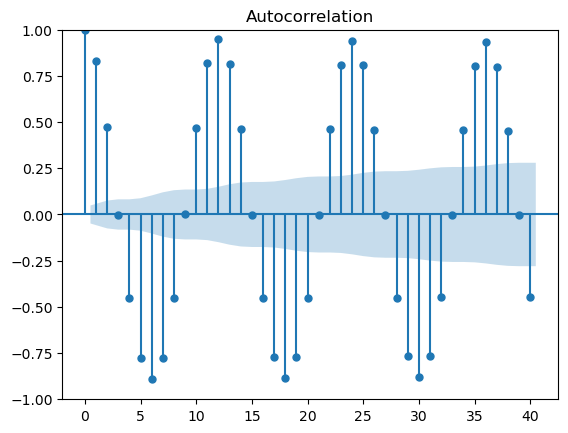

In [47]:
sm.graphics.tsa.plot_acf(mean_temp_monthly.squeeze(), lags=40)
plt.show()

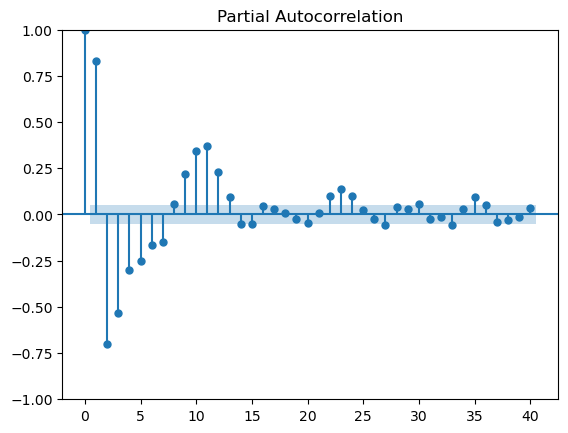

In [48]:
sm.graphics.tsa.plot_pacf(mean_temp_monthly.squeeze(), lags=40, method="ywm")
plt.show()

And yes, the autocorrelation and the partial autocorrelation are effectively demonstrating the annual structure in the temperature series. The seasonal regularity and the structural movement don't seem to show a longer-term cyclical repurcussion from these graphs. So the key component to forecast the temperature will be the seasonal fluctuation along the year.